# 📦 Step 1: Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import warnings
import os

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


# 📥 Step 2: Load Dataset

In [5]:
df = pd.read_csv("data/ecommerce_dataset_updated.csv")
print("Initial shape:", df.shape)

print("🧾 Columns in dataset:\n")
print(df.columns.tolist())


Initial shape: (3660, 8)
🧾 Columns in dataset:

['User_ID', 'Product_ID', 'Category', 'Price (Rs.)', 'Discount (%)', 'Final_Price(Rs.)', 'Payment_Method', 'Purchase_Date']


📊 First Look

In [6]:
df.info()
df.describe(include='all')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           3660 non-null   object 
 1   Product_ID        3660 non-null   object 
 2   Category          3660 non-null   object 
 3   Price (Rs.)       3660 non-null   float64
 4   Discount (%)      3660 non-null   int64  
 5   Final_Price(Rs.)  3660 non-null   float64
 6   Payment_Method    3660 non-null   object 
 7   Purchase_Date     3660 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 228.9+ KB


,User_ID,Product_ID,Category,Price (Rs.),Discount (%),Final_Price(Rs.),Payment_Method,Purchase_Date
0,337c166f,f414122f-e,Sports,36.53,15,31.05,Net Banking,12-11-2024
1,d38a19bf,fde50f9c-5,Clothing,232.79,20,186.23,Net Banking,09-02-2024
2,d7f5f0b0,0d96fc90-3,Sports,317.02,25,237.76,Credit Card,01-09-2024
3,395d4994,964fc44b-d,Toys,173.19,25,129.89,UPI,01-04-2024
4,a83c145c,d70e2fc6-e,Beauty,244.80,20,195.84,Net Banking,27-09-2024


# Step 3: Data Cleaning

🧹 Drop Duplicates and Nulls

In [7]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['User_ID', 'Final_Price(Rs.)'], inplace=True)

🗓️ Parse and extract time features

In [8]:
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
df = df.dropna(subset=['Purchase_Date'])
df['Year'] = df['Purchase_Date'].dt.year
df['Month'] = df['Purchase_Date'].dt.month
df['Weekday'] = df['Purchase_Date'].dt.day_name()

🧽 Clean Text Columns

In [9]:
df['Category'] = df['Category'].str.upper().str.strip()
df['Payment_Method'] = df['Payment_Method'].str.title().str.strip()

# 🧑‍💻 Step 4: Feature Engineering for RFM (Frequency, Monetary)

Frequency: Count of purchases per user

In [11]:
np.random.seed(42)
user_ids = df['User_ID'].unique()
random_freq = np.random.randint(1, 10, size=len(user_ids))
frequency_df = pd.DataFrame({'User_ID': user_ids, 'Customer_Frequency': random_freq})


💰 Monetary: Total spending per user

In [12]:
monetary_df = df.groupby('User_ID')['Final_Price(Rs.)'].sum().reset_index(name='Total_Spending')

🧩 Merge features into a single customer profile table (no conflicts)

In [13]:
customer_df = df[['User_ID']].drop_duplicates()
customer_df = customer_df.merge(frequency_df, on='User_ID', how='left')
customer_df = customer_df.merge(monetary_df, on='User_ID', how='left')

🧮 AOV = Total Spending / Frequency

In [14]:
customer_df['AOV'] = customer_df['Total_Spending'] / customer_df['Customer_Frequency']

📉 Discount Sensitivity (per transaction)

In [15]:
df['Discount_Sensitivity'] = df['Discount (%)'] * df['Final_Price(Rs.)']

👉 Average Discount Sensitivity per customer

In [16]:
discount_df = df.groupby('User_ID')['Discount_Sensitivity'].mean().reset_index(name='Avg_Discount_Sensitivity')

➕ Merge this into customer profile

In [17]:
customer_df = customer_df.merge(discount_df, on='User_ID', how='left')

✅ Final Check

In [18]:
print("🎯 Final customer profile shape:", customer_df.shape)
customer_df.head()

🎯 Final customer profile shape: (1454, 5)


,User_ID,Customer_Frequency,Total_Spending,AOV,Avg_Discount_Sensitivity
0,337c166f,7,31.05,4.435714,465.75
1,d38a19bf,4,186.23,46.557500,3724.60
2,d7f5f0b0,8,237.76,29.720000,5944.00
3,395d4994,5,129.89,25.978000,3247.25
4,3fdcdae8,7,120.93,17.275714,6046.50


# 🧪 Step 5: Feature Scaling + PCA

🎯 Features to scale

In [19]:
        features = ['Customer_Frequency', 'Total_Spending', 'AOV', 'Avg_Discount_Sensitivity']
        X = customer_df[features]

⚖️ Standardize the features

In [20]:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

📉 PCA for dimensionality reduction (2D for visualization)

In [21]:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

Add PCA components back to customer_df for plotting

In [22]:
        customer_df['PCA1'] = X_pca[:, 0]
        customer_df['PCA2'] = X_pca[:, 1]

        print("✅ PCA explained variance ratio:", pca.explained_variance_ratio_)

✅ PCA explained variance ratio: [0.4608325  0.30909597]


# 🧠 Step 6: Customer Segmentation using Clustering Algorithms

# ✅ Part 1: KMeans Clustering

🔍 6.1 Elbow Method to find optimal k

Try different k values

In [23]:
sse = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


📈 Plot Elbow & Silhouette Scores

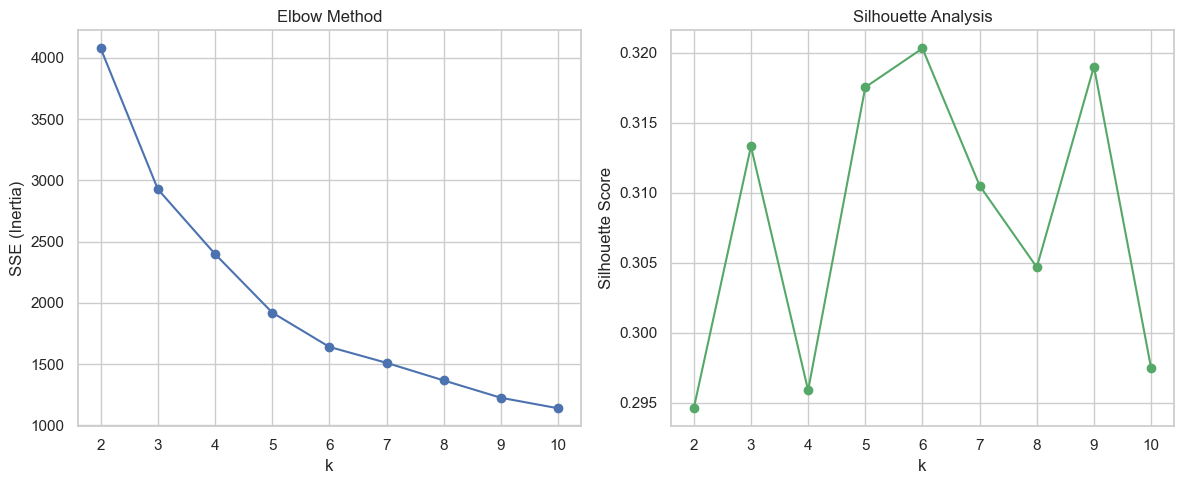

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, sse, 'bo-')
plt.xlabel("k")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.savefig("visuals/kmeans_elbow_silhouette.png")
plt.show()

⚙️ 6.2 Apply Optimal KMeans 

Fit KMeans with optimal k(4)

In [25]:
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

🎨 Visualize Clusters

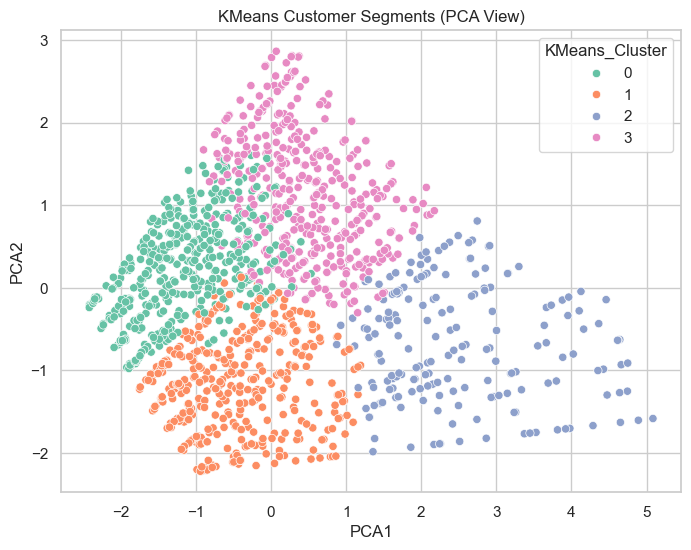

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set2')
plt.title("KMeans Customer Segments (PCA View)")
plt.savefig("visuals/kmeans_pca_clusters.png")
plt.show()

# 🧬 Part 2 : Agglomerative Clustering (Hierarchical)

🧭 First: Plot dendrogram to visually choose cluster count

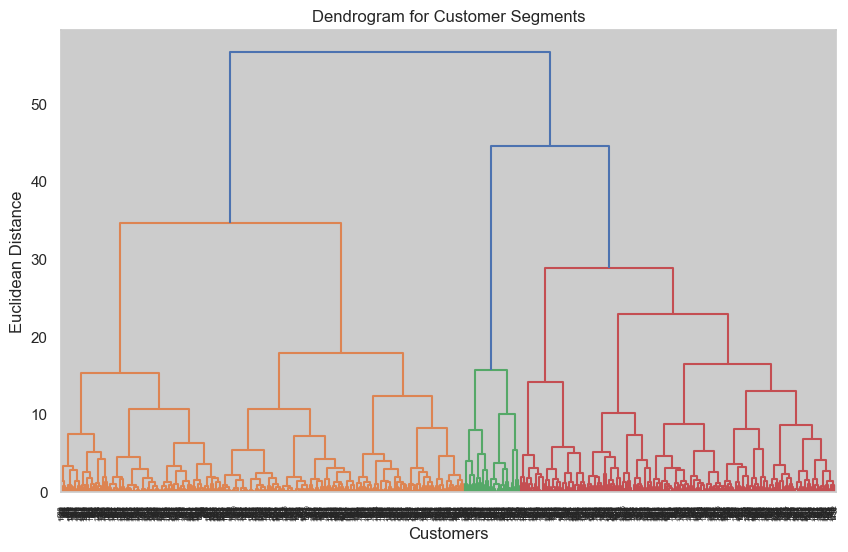

In [27]:


plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrogram for Customer Segments")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.savefig("visuals/dendrogram.png")
plt.show()


🧪 Fit Agglomerative Model

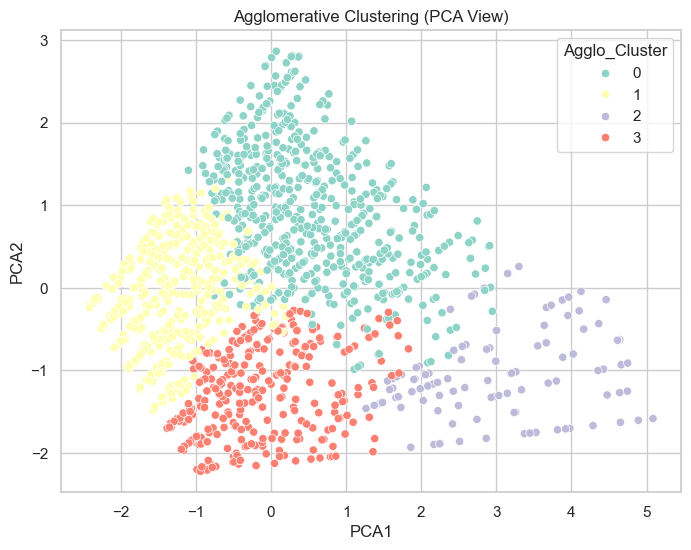

In [28]:
agglo = AgglomerativeClustering(n_clusters=4)
customer_df['Agglo_Cluster'] = agglo.fit_predict(X_scaled)

#📌 Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x='PCA1', y='PCA2', hue='Agglo_Cluster', palette='Set3')
plt.title("Agglomerative Clustering (PCA View)")
plt.savefig("visuals/agglo_pca_clusters.png")
plt.show()

# ✅ Step 7: Customer Segment Profiling

🎯 Step 7.1: Define Correct Feature Set

In [29]:
features = ['AOV', 'Customer_Frequency', 'Avg_Discount_Sensitivity', 'Total_Spending']

🧮 Step 7.2: Profile KMeans Clusters

In [30]:

kmeans_profile = customer_df.groupby('KMeans_Cluster')[features].mean().round(2)
print("📋 KMeans Cluster Profiles:\n", kmeans_profile)

📋 KMeans Cluster Profiles:
                    AOV  Customer_Frequency  Avg_Discount_Sensitivity  \
KMeans_Cluster                                                         
0                23.68                7.40                   1581.81   
1                45.80                2.90                   1756.01   
2               223.69                1.57                   4286.52   
3                57.97                5.78                   6460.19   

                Total_Spending  
KMeans_Cluster                  
0                       169.14  
1                       104.73  
2                       309.02  
3                       294.93  


🏷️ Step 7.3: Assign Human-Friendly Segment Labels (based on KMeans)

In [31]:
features = ['AOV', 'Customer_Frequency', 'Avg_Discount_Sensitivity', 'Total_Spending']
kmeans_profile = customer_df.groupby('KMeans_Cluster')[features].mean()

high_spender_cluster = kmeans_profile['Total_Spending'].idxmax()
frequent_buyer_cluster = kmeans_profile['Customer_Frequency'].idxmax()
deal_seeker_cluster = kmeans_profile['Avg_Discount_Sensitivity'].idxmax()

all_clusters = set(kmeans_profile.index)
remaining_cluster = list(all_clusters - {high_spender_cluster, frequent_buyer_cluster, deal_seeker_cluster})[0]

cluster_label_map = {
    high_spender_cluster: "🎯 High Spender",
    frequent_buyer_cluster: "🔁 Frequent Buyer",
    deal_seeker_cluster: "🛍️ Deal Seeker",
    remaining_cluster: "😴 Low Value"
}

customer_df['Segment'] = customer_df['KMeans_Cluster'].map(cluster_label_map)

🧮 Step 7.4: Profile Agglomerative Clusters 

In [32]:

agglo_profile = customer_df.groupby('Agglo_Cluster')[features].mean().round(2)
print("\n📋 Agglomerative Cluster Profiles:\n", agglo_profile)


📋 Agglomerative Cluster Profiles:
                   AOV  Customer_Frequency  Avg_Discount_Sensitivity  \
Agglo_Cluster                                                         
0               67.75                5.52                   5643.37   
1               19.21                6.82                   1502.32   
2              278.51                1.00                   4524.04   
3               60.69                2.28                   1718.05   

               Total_Spending  
Agglo_Cluster                  
0                      302.74  
1                      126.97  
2                      278.51  
3                      120.05  


🏷️ Step 7.5: Assign Segment Labels for Agglomerative

In [33]:
features = ['AOV', 'Customer_Frequency', 'Avg_Discount_Sensitivity', 'Total_Spending']
agglo_profile = customer_df.groupby('Agglo_Cluster')[features].mean()

high_spender_cluster = agglo_profile['Total_Spending'].idxmax()
frequent_buyer_cluster = agglo_profile['Customer_Frequency'].idxmax()
deal_seeker_cluster = agglo_profile['Avg_Discount_Sensitivity'].idxmax()

all_clusters = set(agglo_profile.index)
remaining_cluster = list(all_clusters - {high_spender_cluster, frequent_buyer_cluster, deal_seeker_cluster})[0]

agglo_cluster_label_map = {
    high_spender_cluster: "🎯 High Spender",
    frequent_buyer_cluster: "🔁 Frequent Buyer",
    deal_seeker_cluster: "🛍️ Deal Seeker",
    remaining_cluster: "😴 Low Value"
}

customer_df['Agglo_Segment'] = customer_df['Agglo_Cluster'].map(agglo_cluster_label_map)

💾 Step 7.5: Export Final Segment-Level Dataset

In [34]:
final_df = customer_df[[
    'User_ID', 'AOV', 'Customer_Frequency', 'Avg_Discount_Sensitivity',
    'Total_Spending', 'Segment', 'PCA1', 'PCA2'
]]
os.makedirs("outputs", exist_ok=True)

final_df.to_csv("outputs/customer_segments.csv", index=False)
print("✅ Segment data saved to: outputs/customer_segments.csv")

print(final_df.head())




✅ Segment data saved to: outputs/customer_segments.csv
    User_ID        AOV  Customer_Frequency  Avg_Discount_Sensitivity  \
0  337c166f   4.435714                   7                    465.75   
1  d38a19bf  46.557500                   4                   3724.60   
2  d7f5f0b0  29.720000                   8                   5944.00   
3  395d4994  25.978000                   5                   3247.25   
4  3fdcdae8  17.275714                   7                   6046.50   

   Total_Spending           Segment      PCA1      PCA2  
0           31.05  🔁 Frequent Buyer -1.943815 -0.595439  
1          186.23       😴 Low Value -0.076105 -0.209562  
2          237.76    🛍️ Deal Seeker -0.472159  1.420481  
3          129.89       😴 Low Value -0.709341 -0.229257  
4          120.93  🔁 Frequent Buyer -0.864049  0.749075  
